# KNN Classifier
The KNN classifier algorithm is used to classify a sample based on number of nearest neighbors.

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from utils import shuffle, train_test_split, min_max_normalize, label_encoder, confusion_matrix, accuracy 
from neighbors import KNNClassifier

In [2]:
iris = pd.read_csv('./data/Iris.csv')

## Preparing the datasets

The first thing to do is to split de dataset in two subsets, the training and the test.

To simplify error metrics algorithms, the target variable, which is a categorical variable, will be transformed from string to integer.

After processing the data, it is necessary to divide the dataset into training and testing. 70% will be used for training and 30% for testing. 

It is necessary to separate the target variable from the other features of each set that forms x_train and y_train, x_test and y_test.

The algorithm performs distance calculations, so it is extremely necessary to normalize the data. For this problem, will be used the min-max normalization.

Note that the normalization function returns two values, which are the normalized dataset, and the values (min and max) used to normalize the data. if use the entire dataset, to generate the min and max values, will be 'cheating on the game'. Its needed to normalize test using min and max values of training set. This is also valid for new entries.



In [3]:
print('Before', [iris['Species'].iloc[0], iris['Species'].iloc[51], iris['Species'].iloc[125]])

iris['Species'], labels = label_encoder(iris['Species'].values.tolist())

print('After', [iris['Species'].iloc[0], iris['Species'].iloc[51], iris['Species'].iloc[125]])

Before ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
After [0, 1, 2]


In [4]:
train, test = train_test_split(iris, train_size=0.7)

# Only for explanation proposal
original_train = train.copy(deep=True)

x_train = train.drop('Species', axis=1)
x_test = test.drop('Species', axis=1)

y_train = train['Species']
y_test = test['Species']

In [5]:
x_train, minmax = min_max_normalize(x_train)
x_test, _ = min_max_normalize(x_test)

It is possible to observe that, before normalizing, the features were at different scales, after normalizing the data, each feature was on the same scale (between zero and one). and without changing its characteristics.

<AxesSubplot:title={'center':'Normalized'}, xlabel='SepalLengthCm', ylabel='Count'>

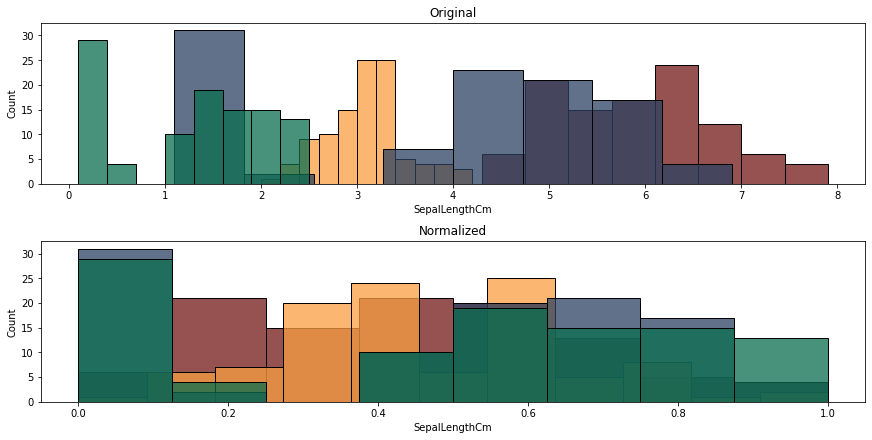

In [6]:
fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = GridSpec(2, 1, figure=fig)

original_ax = fig.add_subplot(gs[0,0], title='Original')
normalized_ax = fig.add_subplot(gs[1,0], title='Normalized')

sns.histplot(x=original_train['SepalLengthCm'], color='#721817', ax=original_ax)
sns.histplot(x=original_train['SepalWidthCm'], color='#fa9f42', ax=original_ax)
sns.histplot(x=original_train['PetalLengthCm'], color='#2b4162', ax=original_ax)
sns.histplot(x=original_train['PetalWidthCm'], color='#0b6e4f', ax=original_ax)

sns.histplot(x=x_train['SepalLengthCm'], color='#721817', ax=normalized_ax)
sns.histplot(x=x_train['SepalWidthCm'], color='#fa9f42', ax=normalized_ax)
sns.histplot(x=x_train['PetalLengthCm'], color='#2b4162', ax=normalized_ax)
sns.histplot(x=x_train['PetalWidthCm'], color='#0b6e4f', ax=normalized_ax)

## Train and Test

In [7]:
%%time
knn = KNNClassifier(k=3)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

Wall time: 1.99 ms


acc 100.00


<AxesSubplot:>

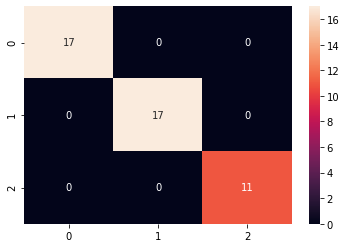

In [8]:
acc = accuracy(y_test, y_pred) * 100
conf = confusion_matrix(y_test, y_pred)
print('acc %.2f' % acc)
sns.heatmap(conf, annot=True)